# 1. Loading the dataset

In [127]:
from pathlib import Path

# Download dataset if it doesn't already exists
if Path("/content/dataset").exists():
  print("dataset already exists, skipping download ...")
else:
  # Step 1: Mount Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Step 2: Define the path to your dataset
  dataset_path = '/content/drive/My Drive/archive.zip'

  # Step 3: Unzip the dataset
  import zipfile
  import os

  with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
      zip_ref.extractall('dataset')

  # Verify extraction
  os.listdir('dataset')


dataset already exists, skipping download ...


# 2. Defining data Transforms

In [128]:
from torchvision import transforms, datasets

data_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
    ])

data_transforms

Compose(
    Grayscale(num_output_channels=1)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

# 3. Extracting train and test dataset and applying transform on them

In [129]:
train_dataset = datasets.ImageFolder(root='dataset/train', transform=data_transforms)
test_dataset = datasets.ImageFolder(root='dataset/test', transform=data_transforms)

total_dataset_length=len(train_dataset)+len(test_dataset)
total_dataset_length, len(train_dataset), len(test_dataset)

(35887, 28709, 7178)

In [130]:
# Split data into traning data into training data and validation data
import torch
from torch.utils.data import random_split

train_size = int(0.7 * total_dataset_length)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Training dataset ratio: {len(train_dataset)/total_dataset_length}")
print(f"Validation dataset ratio: {len(val_dataset)/total_dataset_length}")
print(f"Test dataset ratio: {len(test_dataset)/total_dataset_length}")




Training dataset ratio: 0.6999749212806866
Validation dataset ratio: 0.10000835957310447
Test dataset ratio: 0.20001671914620894


In [131]:
# Trying to understand the dataset
X_train,y_train=train_dataset[4]

X_train.shape,y_train

(torch.Size([1, 48, 48]), 1)

Text(0.5, 1.0, '1')

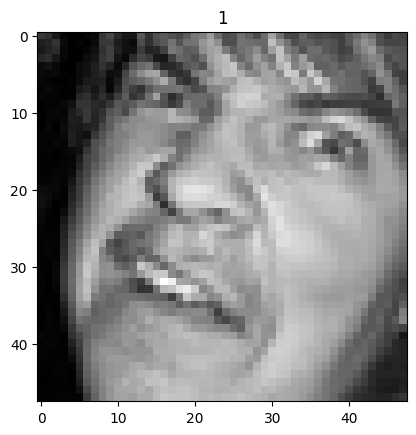

In [132]:
#Visualizing our data

import matplotlib.pyplot as plt
plt.imshow(X_train.squeeze(), cmap="gray")
plt.title(y_train)

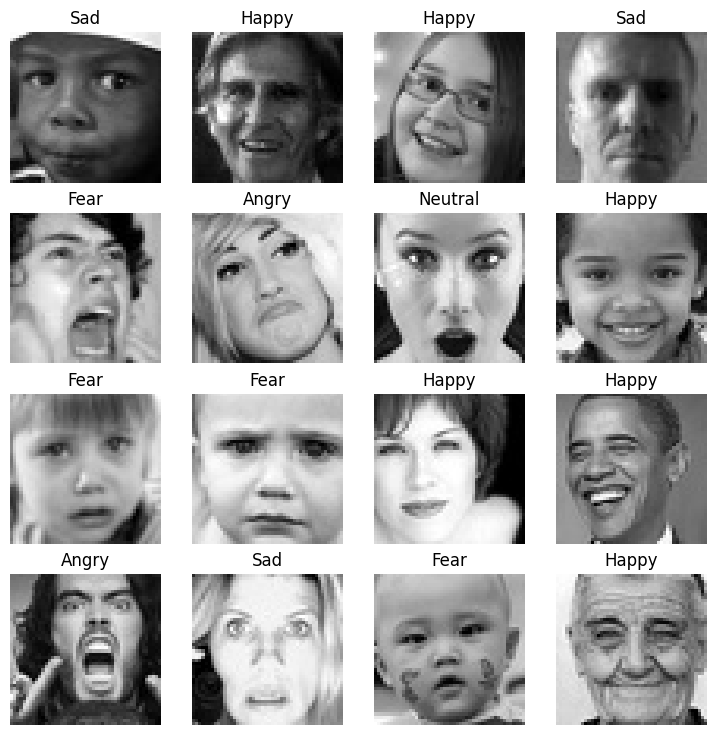

In [133]:
#Plot more images
torch.manual_seed(42)
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig=plt.figure(figsize=(9,9))

rows,cols=4,4
for i in range(1,rows*cols+1):
  random_idx=torch.randint(0,len(train_dataset),size=[1]).item()
  X_train,y_train=train_dataset[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(X_train.squeeze(),cmap="gray")
  plt.title(emotions[y_train])
  plt.axis(False)

In [134]:
# Create DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_dataloader


In [135]:
# Feature batches and labels

train_features_batch,train_labels_batch=next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([64, 1, 48, 48]), torch.Size([64]))

In [136]:
#Importing a helper function
import requests
from pathlib import Path

#Download helper functions from Learn PyTorch repo

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download ...")
else:
  print("Downloading helper_functions.py")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download ...


In [137]:
device="cude" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [138]:
# Write a eval function to evaluate models

from tqdm.auto import tqdm

torch.manual_seed(42)

def eval_model( model : torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
              device : torch.device=device):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss,acc=0,0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X,y=X.to(device), y.to(device)
      #Make predictions
      y_pred=model(X)

      #Accumulate the loss and acc values per batch
      loss+=loss_fn(y_pred,y)
      acc+=accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    #Scale loss and acc to find the avg loss/acc per batch
    loss/=len(data_loader)
    acc/=len(data_loader)

  return {
      "model_name": model.__class__.__name__, #only works when model was created with class
      "model_loss": loss.item(),
      "model_acc": acc}

In [139]:
# Write a function for train_step

def train_step(model : torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):
  """Performs a training with model trying to learn on data_loader."""

  train_loss, train_acc=0,0

  model.train()
  #Add a loop to loop through the training batches
  for batch, (X,y) in enumerate(data_loader):
    #Put data on target device
    X,y=X.to(device), y.to(device)

    #1. Forward pass
    y_pred=model(X)

    #2 Calculate loss and accuracy (per batch)
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    train_acc+=accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  #Divice total train loss and acc by length of data loader
  train_loss/=len(data_loader)
  train_acc/=len(data_loader)


  print(f"\nTrain loss : {train_loss:.5f} |  Train acc: {train_acc:.2f}%")

In [140]:
# Write a function for test step

def test_step(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  test_loss, test_acc=0,0

  model.eval()

  with torch.inference_mode():
    for batch,(X,y) in enumerate(data_loader):
      X,y=X.to(device), y.to(device)

      # 1. Forward Pass
      y_test_pred=model(X)

      # 2. Loss and accuracy
      test_loss+=loss_fn(y_test_pred,y)
      test_acc+=accuracy_fn(y_true=y, y_pred=y_test_pred.argmax(dim=1))

    #Calculating average
    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

  print(f"\nTest loss : {test_loss:.5f} |  Test acc: {test_acc:.2f}%")

In [141]:
# Building a LSTM class for our model

import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x is expected to have dimensions (batch_size, input_size)
        batch_size = x.size(0)
        x = x.view(batch_size, 1, -1)  # Reshape to (batch_size, seq_len=1, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model_0=LSTMModel(input_size=48*48, hidden_size=128, num_layers=2, num_classes=len(emotions)).to(device)

model_0


LSTMModel(
  (lstm): LSTM(2304, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

In [142]:
# Optimizer and loss func
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [143]:
torch.manual_seed(42)
epochs=3

for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch} \n --------")
  train_step(model= model_0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device="cpu")
  test_step(model= model_0,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device="cpu")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0 
 --------

Train loss : 1.68232 |  Train acc: 33.15%

Test loss : 1.60924 |  Test acc: 37.18%
Epoch 1 
 --------

Train loss : 1.57040 |  Train acc: 38.75%

Test loss : 1.56631 |  Test acc: 38.33%
Epoch 2 
 --------

Train loss : 1.50972 |  Train acc: 41.52%

Test loss : 1.55850 |  Test acc: 39.07%


In [144]:
model_0_results=eval_model(model=model_0,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn,
                           device="cpu")

model_0_results

  0%|          | 0/113 [00:00<?, ?it/s]

{'model_name': 'LSTMModel',
 'model_loss': 1.5585044622421265,
 'model_acc': 39.06803097345133}